In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statistics import mean
from typing import Dict, List, Tuple

Setting a random seed ensures reproducibility of results when using functions that rely on randomness from numpy.

In [2]:
np.random.seed(42)

Neural Network Class (Neural):

- Constructor (__init__): Initializes the neural network with parameters including the structure of layers, number of epochs, learning rate, batch size, validation split, and verbosity level.
- fit Method: Trains the neural network using the provided data (X and y). It splits the data into training and validation sets, initializes the network layers, iterates over epochs, performs forward and backward passes, and updates the network weights.
- predict Method: Predicts the output for given input data (X) using the trained model.
- plot_learning Method: Plots the learning curves showing the training and validation losses over epochs.
- Private Methods:
  - init_layers: Initializes the weights and biases for the layers of the neural network.
  - forward: Performs the forward pass through the network, calculating the output of each layer.
  - calculate_loss: Calculates the loss between predicted and actual values (mean squared error).
  - calculate_mse: Calculates the mean squared error between actual and predicted values.
  - backward: Performs the backward pass through the network, updating the weights using gradient descent.


- Forward Pass: In __forward, the input data is propagated forward through the network layers using matrix multiplication and activation functions (ReLU in this case).
- Backward Pass (Backpropagation): In __backward, the gradients of the loss with respect to the weights and biases are computed and used to update the weights of each layer in the opposite direction of the gradient.
- Training Loop: The fit method iterates over epochs, performing forward and backward passes for each batch of data. It calculates and tracks the training and validation losses for monitoring the model's performance.
- Weight Initialization: Weights are initialized randomly using np.random.rand, and biases are initialized to ones. This helps break symmetry and prevents the gradients from vanishing or exploding.
- Activation Function: ReLU (Rectified Linear Activation) function is used for hidden layers (np.maximum(batch, 0)), which introduces non-linearity into the network.
- Gradient Descent: Weights and biases are updated using gradient descent (__backward), where the gradients are multiplied by the learning rate and subtracted from the current weights and biases.

In [3]:
class Neural:
    
    def __init__(self, layers: List[int], epochs: int, 
                 learning_rate: float = 0.001, batch_size: int=32,
                 validation_split: float = 0.2, verbose: int=1):
        self._layer_structure: List[int] = layers
        self._batch_size: int = batch_size
        self._epochs: int = epochs
        self._learning_rate: float = learning_rate
        self._validation_split: float = validation_split
        self._verbose: int = verbose
        self._losses: Dict[str, float] = {"train": [], "validation": []}
        self._is_fit: bool = False
        self.__layers = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # validation split
        X, X_val, y, y_val = train_test_split(X, y, test_size=self._validation_split, random_state=42)
        # initialization of layers
        self.__layers = self.__init_layers()
        for epoch in range(self._epochs):
            epoch_losses = []
            for i in range(1, len(self.__layers)):
                # forward pass
                x_batch = X[i:(i+self._batch_size)]
                y_batch = y[i:(i+self._batch_size)]
                pred, hidden = self.__forward(x_batch)
                # calculate loss
                loss = self.__calculate_loss(y_batch, pred)
                epoch_losses.append(np.mean(loss ** 2))
                #backward
                self.__backward(hidden, loss)
            valid_preds, _ = self.__forward(X_val)
            train_loss = mean(epoch_losses)
            valid_loss = np.mean(self.__calculate_mse(valid_preds,y_val))
            self._losses["train"].append(train_loss)
            self._losses["validation"].append(valid_loss)
            if self._verbose:
                print(f"Epoch: {epoch} Train MSE: {train_loss} Valid MSE: {valid_loss}")
        self._is_fit = True
        return
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        if self._is_fit == False:
            raise Exception("Model has not been trained yet.")
        pred, hidden = self.__forward(X)
        return pred
    
    def plot_learning(self) -> None:
        plt.plot(self._losses["train"],label="loss")
        plt.plot(self._losses["validation"],label="validation")
        plt.legend()
    
    def __init_layers(self) -> List[np.ndarray]:
        layers = []
        for i in range(1, len(self._layer_structure)):
            layers.append([
                np.random.rand(self._layer_structure[i-1], self._layer_structure[i]) / 5 - .1,
                np.ones((1,self._layer_structure[i]))
            ])
        return layers
    
    def __forward(self, batch: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        hidden = [batch.copy()]
        for i in range(len(self.__layers)):
            batch = np.matmul(batch, self.__layers[i][0]) + self.__layers[i][1]
            if i < len(self.__layers) - 1:
                batch = np.maximum(batch, 0)
            # Store the forward pass hidden values for use in backprop
            hidden.append(batch.copy())
        return batch, hidden
    
    def __calculate_loss(self,actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        "mse"
        return predicted - actual
    
    
    def __calculate_mse(self, actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        return (actual - predicted) ** 2
    
    def __backward(self, hidden: List[np.ndarray], grad: np.ndarray) -> None:
        for i in range(len(self.__layers)-1, -1, -1):
            if i != len(self.__layers) - 1:
                grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))
    
            w_grad = hidden[i].T @ grad
            b_grad = np.mean(grad, axis=0)
    
            self.__layers[i][0] -= w_grad * self._learning_rate
            self.__layers[i][1] -= b_grad * self._learning_rate
            
            grad = grad @ self.__layers[i][0].T
        return

generate_data function : creates synthetic data with specified correlations between features.

- Correlation Values: corr_a, corr_b, and corr_c represent the correlation coefficients between independent features a, b, and c respectively, and the target feature.

- Independent Features Generation: Independent features a, b, and c are generated from normal distributions with mean 0 and standard deviation 1, each containing 100,000 samples.
  - Feature d is generated from a discrete uniform distribution between 0 and 4, containing 100,000 samples.
  - Feature e is generated from a binomial distribution with 0.5 probability of success (i.e., 1) and 100,000 trials.

- Target Feature Generation: The target feature is generated based on the independent features and the specified correlations.
It is computed as a linear combination of the independent features (a, b, c, d, e) with coefficients (corr_a, corr_b, corr_c) along with some noise from a normal distribution with mean 0 and standard deviation 10.
Additionally, contributions from features d and e are scaled by 10 and 20 respectively.

- DataFrame Creation: pandas DataFrame (df) is created to hold all the generated features, including the independent features (a, b, c, d, e) and the target feature.
The DataFrame is returned as the output of the function. 

In [4]:
def generate_data():
    # Define correlation values
    corr_a = 0.8
    corr_b = 0.4
    corr_c = -0.2
    
    # Generate independent features
    a = np.random.normal(0, 1, size=100000)
    b = np.random.normal(0, 1, size=100000)
    c = np.random.normal(0, 1, size=100000)
    d = np.random.randint(0, 4, size=100000)
    e = np.random.binomial(1, 0.5, size=100000)
    
    # Generate target feature based on independent features
    target = 50 + corr_a*a + corr_b*b + corr_c*c + d*10 + 20*e + np.random.normal(0, 10, size=100000)
    
    # Create DataFrame with all features
    df = pd.DataFrame({'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'target': target})
    return df

- The generate_data function is called to create a synthetic dataset (df) with features and a target variable.
- Features (X) and the target variable (y) are separated from the DataFrame (df).
- Standard scaling is applied to the features using StandardScaler() to normalize them.
- The dataset is split into training and testing sets using train_test_split.
- The structure of the neural network is defined as [input_size, 10, 10, 1], indicating an input layer with the same size as the number of features, followed by two hidden layers with 10 neurons each, and an output layer with one neuron.
- An instance of the Neural class (nn) is created with specified parameters: 20 epochs, learning rate of 1e-5, batch size of 64, and a validation split of 0.2.
- The fit method of the Neural class is called to train the neural network on the training data (X_train, y_train).

- Prediction and Evaluation:
  - The trained model (nn) is used to predict the target variable for the test data (X_test) using the predict method.
  - Learning curves are plotted using the plot_learning method to visualize the training and validation losses over epochs.
  - Mean squared error is calculated between the predicted and actual target values for the test set using mean_squared_error from sklearn.metrics.
  - The test error is printed to evaluate the performance of the model.

Epoch: 0 Train MSE: 6066.584227303851 Valid MSE: 5630.972575612107
Epoch: 1 Train MSE: 5870.45827241517 Valid MSE: 5384.024826048717
Epoch: 2 Train MSE: 5584.489636840577 Valid MSE: 4993.952466830458
Epoch: 3 Train MSE: 5127.642385432671 Valid MSE: 4376.563641292963
Epoch: 4 Train MSE: 4408.550555767417 Valid MSE: 3470.967255214888
Epoch: 5 Train MSE: 3370.6165240733935 Valid MSE: 2333.4365011529103
Epoch: 6 Train MSE: 2112.702666917853 Valid MSE: 1245.1547720938968
Epoch: 7 Train MSE: 1001.3618108374816 Valid MSE: 565.5834115291266
Epoch: 8 Train MSE: 396.95140965489935 Valid MSE: 298.31216370120575
Epoch: 9 Train MSE: 198.2900609070307 Valid MSE: 204.83294115572235
Epoch: 10 Train MSE: 139.29311821219008 Valid MSE: 162.0341771457693
Epoch: 11 Train MSE: 113.97162125348699 Valid MSE: 138.3549189707446
Epoch: 12 Train MSE: 100.19734344395454 Valid MSE: 124.6017015640054
Epoch: 13 Train MSE: 92.35069581444299 Valid MSE: 116.55999261926034
Epoch: 14 Train MSE: 87.88890529435344 Valid MSE

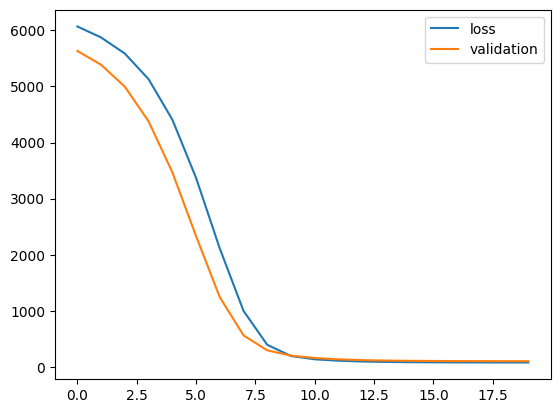

In [5]:
df = generate_data()

# Separate the features and target
X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

layer_structure = [X_train.shape[1],10,10,1]
nn = Neural(layer_structure, 20, 1e-5, 64, 0.2, 1)

nn.fit(X_train, y_train)

y_pred = nn.predict(X_test)
nn.plot_learning()

print("Test error: ",mean_squared_error(y_test, y_pred))

A- What I've learned from this code:

This code demonstrates the implementation of a basic feedforward neural network using numpy.

I've learned about the fundamental components of a neural network, including forward and backward propagation, weight initialization, activation functions, and gradient descent optimization. 

Additionally, I've gained insight into generating synthetic data with specified correlations for testing machine learning models.

B- Describe the results:

The neural network was trained for 20 epochs on the generated dataset, with a decreasing trend in both training and validation mean squared errors (MSE) over epochs.

The training MSE started at a high value of around 6066 and gradually decreased to approximately 82.5, indicating improvement in the model's performance.
 
Similarly, the validation MSE decreased from around 5631 to approximately 105.4. 

The test error, calculated as the MSE between predicted and actual target values for the test set, was approximately 105.4, which aligns with the validation MSE.

C- Conclusion:

the neural network learned from the training data, and we could see this because the errors decreased as it learned more. 

When we tested it on new data (the test set), it still performed well with low errors. However, there's room for improvement by adjusting some settings.

Also, creating fake data with specific patterns helped us test the model's abilities in various situations.